Found 40 Files
Read all Files
Made numpy arrays and deleted return array
Binnned particles into maps
29659070
Starting to Calculate Convergences
Calculated Convergences


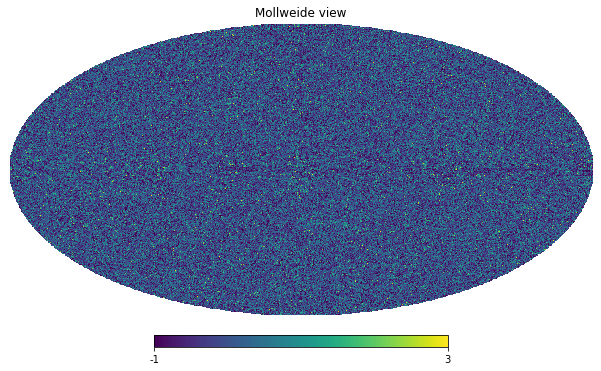

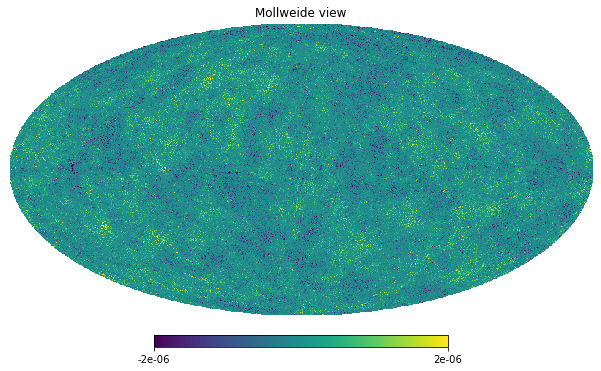

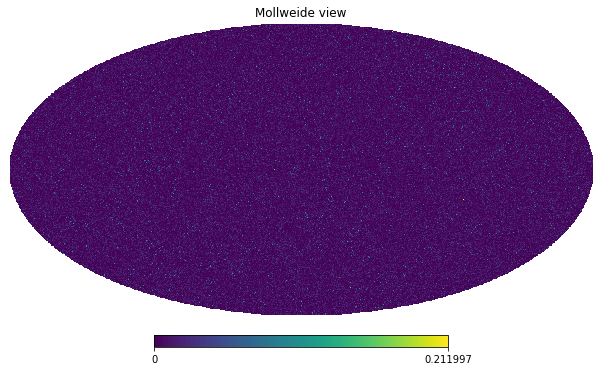

In [1]:
import struct
import numpy as np
import os
from joblib import Parallel, delayed


# In[2]:


#import matplotlib.pyplot as plt
import healpy as hp
nside = 1024
npix = hp.nside2npix(nside)

#%matplotlib inline


# In[3]:


rangeOfInterest=2048 #only look at particles within this

radialDivs = 8

ROIs = np.linspace(0,rangeOfInterest, radialDivs+1)

boxSize=4096 # side length of box
particleSize=512 #the total number of particles is n**3

run_Ident = "_NS_"+str(nside)+"_R_"+str(rangeOfInterest)+"_P_"+str(particleSize)+"_DV_"+str(radialDivs)


# In[4]:
#this can convert cartesian data into radial data
#velocity still needs to be divided by angular diamter distance squared
import ProcessingFunctions

# In[5]:


# code for determinig angular diameter distance from comving distance

from classy import Class
from scipy.interpolate import interp1d

LambdaCDM = Class()

LambdaCDM.set({ 'omega_b':0.022032 , 'omega_cdm' :0.12038 , 'h':0.67556 , 'A_s':2.215e-9 , 'n_s' :0.9619 , 'tau_reio' :0.0925})

LambdaCDM.set({ 'output' :'tCl,pCl,lCl,mPk','lensing' :'yes' ,'P_k_max_1/Mpc': 3.0})

LambdaCDM.compute()

comovDist = LambdaCDM.get_background()['comov. dist.']
angDiaDist = LambdaCDM.get_background()['ang.diam.dist.']
redshifts = LambdaCDM.get_background()['z']

getAngDiaDist = interp1d(comovDist,angDiaDist)
getRedshift = interp1d(comovDist, redshifts)

def getScalingFactor(comov_dist):
    return 1/(1+getRedshift(comov_dist))

del comovDist
del angDiaDist
del redshifts
del LambdaCDM


# Reading lp-cola unformatted files
def unf_read_file(file, p_list=[], np=6):
    with open(file, mode='rb') as f:
        tot_n = 0
        cnt = 0
        while (True):
            cnt += 1
            r = f.read(4)
            if not r: break
            a1 = struct.unpack('i', r)
            r = f.read(a1[0])
            n = struct.unpack('i', r)
            r = f.read(8)
            a, b = struct.unpack('2i', r)
            r = f.read(b)
            p_list.extend(struct.unpack(str(n[0] * np) + 'f', r))
            r = f.read(4)
            tot_n += n[0]
    f.close()
    return tot_n


# In[8]:

direc = "./Data/"
inputFiles = os.listdir(direc)
print("Found "+str(len(inputFiles))+" Files")

#import time

def readSetToBins(fileName, index):
    tempArray = []
    path = direc + fileName

    if os.path.isfile(path):

        unf_read_file(path, p_list=tempArray)
        #print("Reading file "+path)
        reshaped = np.reshape(tempArray,(-1,6))

        tempArray = []

        numParticles = reshaped.shape[0]

        #which radial bin each particle is in
        partRadial =  np.zeros(numParticles)

        offset = np.append((boxSize/2)*np.ones((np.shape(reshaped)[0],3)),np.zeros((np.shape(reshaped)[0],3)),axis=1)

        reshaped = np.subtract(reshaped,offset)
        del offset

        sphereConversion = ProcessingFunctions.convertToSpherical(reshaped)
        del reshaped
        #reshaped = []

        partVelocity = sphereConversion[:,3]/np.power(getAngDiaDist(sphereConversion[:,0]),2)


        partIndex = hp.ang2pix(nside,sphereConversion[:,1],sphereConversion[:,2])

        for j in range(0,radialDivs):
            #set the values of the array to the correspodning radial bin

            partRadial[(sphereConversion[:,0]>ROIs[j]) & (sphereConversion[:,0]<ROIs[j+1])] = j

        partRadial[(sphereConversion[:,0]>ROIs[j+1])] = -1

    #print(str(index)+" done")

    return [partIndex,partRadial, partVelocity]


# In[9]:

num_Files = len(inputFiles)
numProcess = num_Files

returnValues = Parallel(n_jobs=25)(delayed(readSetToBins)(inputFiles[i], i) for i in range(0,numProcess))

#big pause here for some reason, the program says its done with the last file but then it take 20 seconds to move on

print("Read all Files")


# In[10]:


#structure of returnValues is weird
#the first length is the number of processes corresponding to each process
#the second length is 3 corresponding to the three arrays that were returned from each process: numcount, totalVelThread
#the third length is
#the fourth length is

#combine the returns from each processor by summing the first axis

#this can be a very memory intensive part:

#make the longest list possible that can hold all of the particles
outputIndicies = np.full((particleSize**3+3000),0)
outputRadial = np.full((particleSize**3+3000),-1)
outputVelocity = np.full((particleSize**3+3000),0.0,dtype=np.double)

#this is where each loop of the array should start writing to the array
beginSec = 0

for i in range(0,numProcess):
    #this is the number of particles in each returned list
    listParticles = returnValues[i][0].shape[0]

    #the first return of each process is particleIndex

    outputIndicies[beginSec:beginSec+listParticles] = returnValues[i][0]

    #the second return is the radial index
    outputRadial[beginSec:beginSec+listParticles] = returnValues[i][1]

    #the third return is the particle's radial Velocity
    outputVelocity[beginSec:beginSec+listParticles] = returnValues[i][2]

    beginSec = beginSec + listParticles
del returnValues

print("Made numpy arrays and deleted return array")

allMaps = ProcessingFunctions.binParticles(outputIndicies, outputRadial.astype(np.int64), outputVelocity, npix, radialDivs)

del outputIndicies
del outputRadial
del outputVelocity

print("Binnned particles into maps")

outputCount = allMaps[0]
outputkSZ = allMaps[1]

del allMaps

#combine the different radial divs for viewing
numcount = np.sum(outputCount,axis=0)
print(sum(numcount))

n_bar = np.average(numcount)
overdensity = (numcount-n_bar)/n_bar

#hp.mollview(numcount,xsize=3200, max=1000)


# In[12]:



#hp.fitsfunc.write_map("MAPS/overdensity"+run_Ident+".fits", overdensity, overwrite=True)
hp.mollview(overdensity, max=3)

# In[13]:


almostkSZ = np.sum(outputkSZ,axis=0)
#hp.mollview(almostkSZ,xsize=3200,min=-30,max=30)


# In[14]:


#plt.hist(almostkSZ,bins=np.linspace(-30,30));


# In[15]:


OmegaB = 0.048
OmegaM = 0.31
fb = OmegaB/OmegaM

h = 0.69
H = (3.2407789/h)*10**-18
G = 6.674*10**-8
unitLength = 3.085678*10**24 #cm/h - This is one megaparsec
#unitMass = 1.989*10**43 #g
unitMass = (3.0*OmegaM*H*H*(boxSize*unitLength)**3)/(8.0*3.14*G*(particleSize**3))
unitVelocity = 10**5 #cm/s

c=2.99792458*10**10

YHe=0.2477
mH=1.6735575*(10**-24) #g
mHe=6.464731*(10**-24) #g
mu = (1-YHe)/mH+YHe/mHe

sigmaT = 6.6524*(10**-25) #cm^2

#convert l-picola units to SI units
correctUnits = outputkSZ*(unitMass*unitVelocity/unitLength**2)
#summation is now in (g/s)

almosterkSZ = -(sigmaT*fb*mu)*(correctUnits/(c*hp.nside2resol(nside)**2))
hp.mollview(almosterkSZ[-1],min=-2*10**-6,max=2*10**-6)
#hp.fitsfunc.write_map("MAPS/kSZ"+run_Ident+".fits", almosterkSZ, overwrite=True)


convergenceFactors = np.zeros((radialDivs,radialDivs));

dr = rangeOfInterest/radialDivs

#for each layer of the kSZ determine the accumalted convergence
for kSZLayer in range(0,radialDivs):
    #add up the convergence contribution of every intervening layer from 0 up to the current kSZ layer
    for lensingLayer in range(0,kSZLayer):
        kSZDist = (kSZLayer+0.5)*(dr)
        lensingLayerDist = (lensingLayer+0.5)*(dr)

        convergenceFactors[kSZLayer,lensingLayer] = (1/(lensingLayerDist*getScalingFactor(lensingLayerDist)))*(kSZDist-lensingLayerDist)/kSZDist


# In[33]:


#Now we determine the convergence maps

def getConvergenceForPixel(pixelIndex):

    dr = rangeOfInterest/radialDivs

    convergencePixels = np.zeros(radialDivs)

    #for each layer of the kSZ determine the accumalted convergence
    for kSZLayer in range(0,radialDivs):
        #add up the convergence contribution of every intervening layer from 0 up to the current kSZ layer
        for lensingLayer in range(0,kSZLayer):
            kSZDist = (kSZLayer+0.5)*(dr)
            lensingLayerDist = (lensingLayer+0.5)*(dr)

            convergencePixels[kSZLayer] = convergencePixels[kSZLayer] + outputCount[lensingLayer,pixelIndex]*(1/(lensingLayerDist*getScalingFactor(lensingLayerDist)))*(kSZDist-lensingLayerDist)/kSZDist

    return convergencePixels

def getConvergenceForPixelMat(pixelIndex):
    return np.dot(convergenceFactors,outputCount[:,pixelIndex])

def getConvergenceForRange(start, finish):
    convergences = np.zeros((finish-start,radialDivs))
    for pixel in range(start, finish):
        convergences[pixel-start] = getConvergenceForPixelMat(pixel)
    return convergences


# In[34]:


npix = hp.nside2npix(nside)
numProcess = 64
pixelSteps = np.linspace(0,npix,numProcess+1).astype(int)
print("Starting to Calculate Convergences")
convergenceReturn = Parallel(n_jobs=-1)(delayed(getConvergenceForRange)(pixelSteps[i],pixelSteps[i+1]) for i in range(0,numProcess))
print("Calculated Convergences")

#to each pixel:\n#convergenceReturn = Parallel(n_jobs=npix)(delayed(getConvergenceForPixel)(pixel) for pixel in range(0,npix))')


# In[35]:


#to not get a ragged array, npix must be divisible by numProcess
convergenceMaps = np.transpose(np.array(convergenceReturn).reshape((npix,radialDivs)))


# In[36]:

H = 72.1*10**3
c=2.998*10**8

H0Squared = (H/c)**2

prefactors = (3/2)*H0Squared*OmegaM*((boxSize)**3)/(particleSize**3*hp.pixelfunc.nside2pixarea(nside))

convergenceMaps = prefactors*convergenceMaps


# In[37]:


hp.mollview(convergenceMaps[-1])
#hp.fitsfunc.write_map("MAPS/convergence"+run_Ident+".fits", convergenceMaps[radialDivs-1], overwrite=True)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [3]:
#making the derivatives
kalms=hp.sphtfunc.map2alm(convergenceMaps[-1])

In [4]:
lmax=hp.Alm.getlmax(len(kalms))
ls, ms = hp.Alm.getlm(lmax)

lFactor = -ls*(ls+1)
lensPotential = kalms/(lFactor)
lensPotential[0]=0+0j

/tmp/ipykernel_870/2199479434.py:5: RuntimeWarning: divide by zero encountered in true_divide
  lensPotential = kalms/(lFactor)
/tmp/ipykernel_870/2199479434.py:5: RuntimeWarning: invalid value encountered in true_divide
  lensPotential = kalms/(lFactor)


In [5]:
lensPot = hp.alm2map(lensPotential,nside)
divLensPot = hp.alm2map_der1(lensPotential,nside)

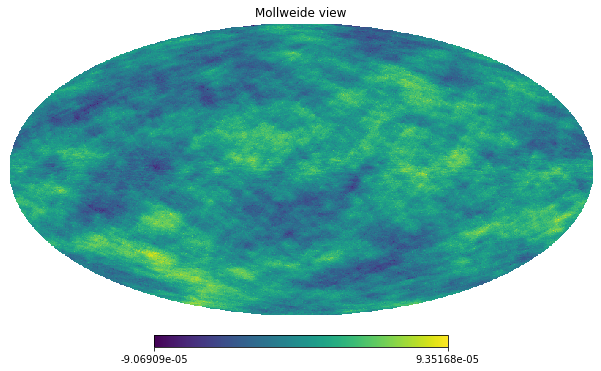

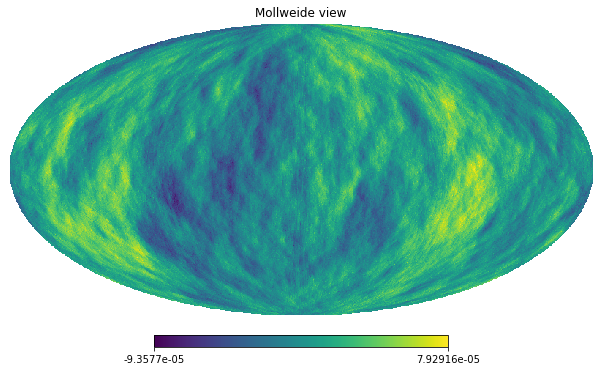

In [6]:
hp.mollview(divLensPot[1])#divergence of theta
hp.mollview(divLensPot[2])#divergence of phi

In [7]:
lmax=hp.Alm.getlmax(len(kalms))
ls, ms = hp.Alm.getlm(lmax)
lFactor = -ls*(ls+1)

baseAngle = hp.pixelfunc.pix2ang(nside, np.arange(0,npix))

lensedkSZ = np.zeros(npix)

for i in range(radialDivs):
    kalms=hp.sphtfunc.map2alm(convergenceMaps[i])
    
    lensPotential = kalms/(lFactor)
    lensPotential[0]=0+0j
    
    divLensPot = hp.alm2map_der1(lensPotential,nside)
    
    deflectedTheta = baseAngle[0]+divLensPot[1]
    deflectedPhi = baseAngle[1]+divLensPot[2]
    
    lensedkSZ = lensedkSZ + hp.pixelfunc.get_interp_val(almosterkSZ[i],deflectedTheta,deflectedPhi)
    

/tmp/ipykernel_870/3045083995.py:12: RuntimeWarning: invalid value encountered in true_divide
  lensPotential = kalms/(lFactor)
/tmp/ipykernel_870/3045083995.py:12: RuntimeWarning: divide by zero encountered in true_divide
  lensPotential = kalms/(lFactor)


In [8]:
psLens = hp.anafast(lensedkSZ)
psUnLens = hp.anafast(np.sum(almosterkSZ,axis=0))

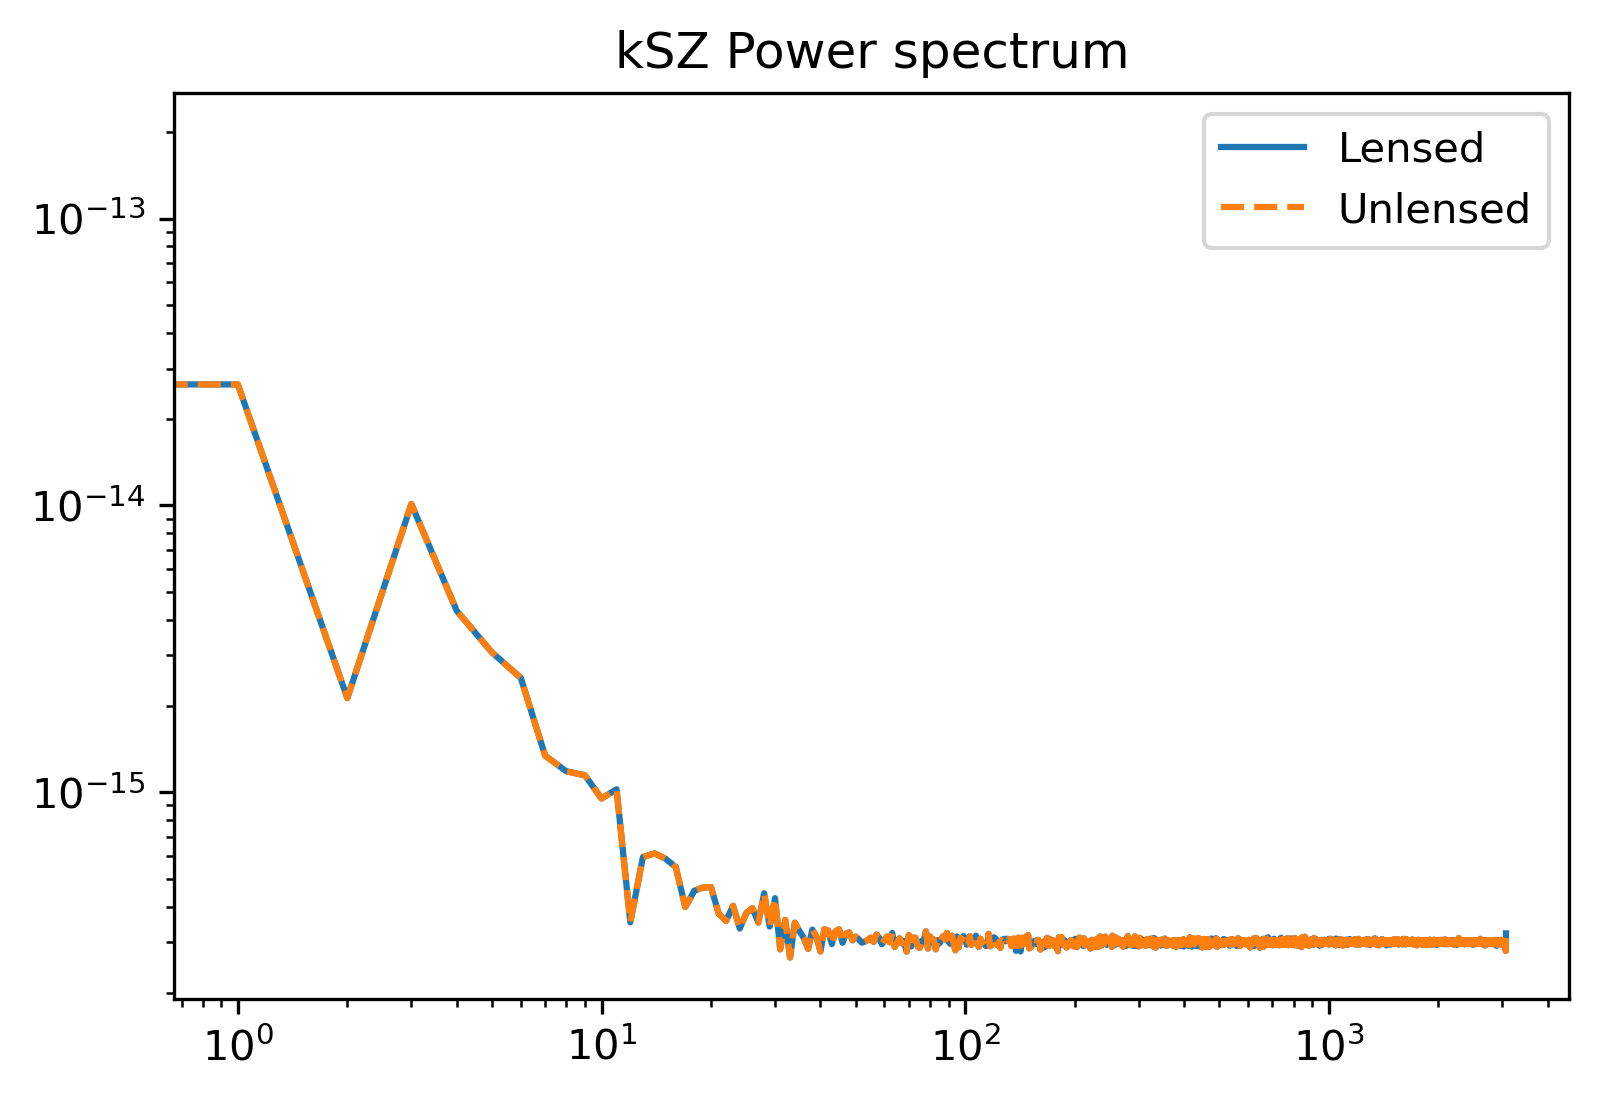

In [9]:
plt.figure(dpi=300)
plt.loglog(psLens);
plt.loglog(psUnLens,"--");
plt.legend(loc=0, labels=["Lensed","Unlensed"])
plt.title("kSZ Power spectrum")
plt.show()

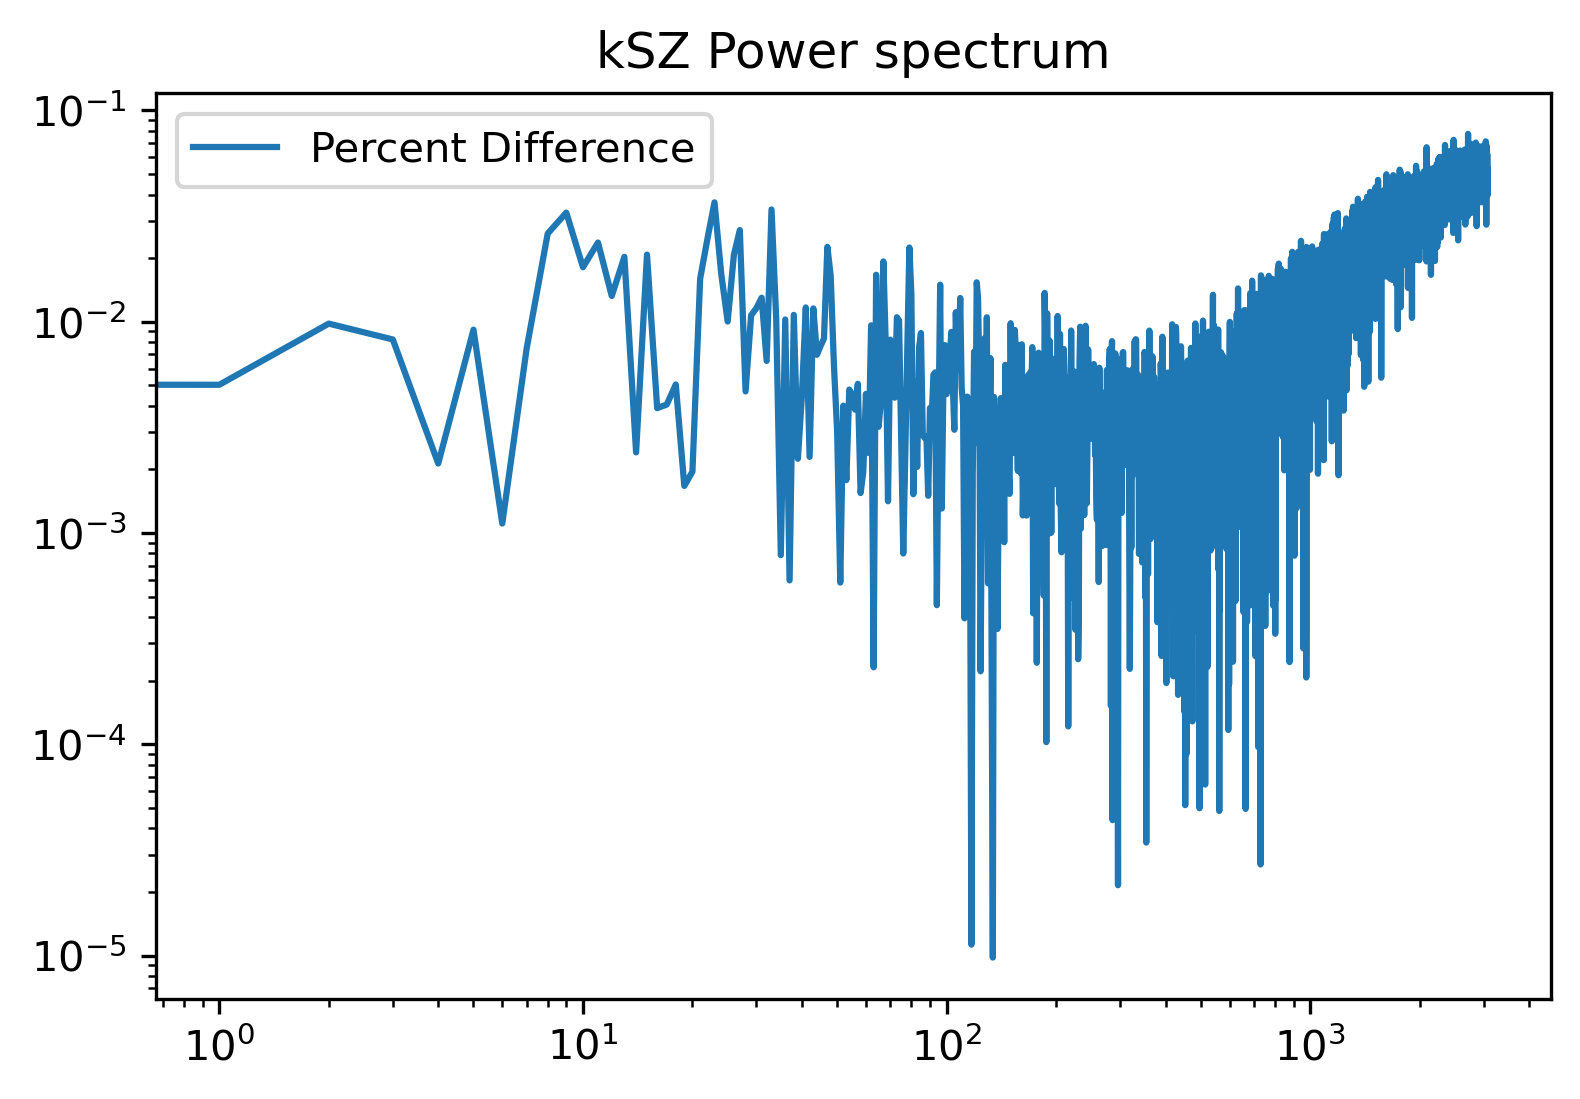

In [10]:
plt.figure(dpi=300)
plt.loglog(np.abs((psLens-psUnLens)/psLens)*100);
plt.legend(loc=0, labels=["Percent Difference"])
plt.title("kSZ Power spectrum")
plt.show()